In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()

# Psychometric Curve

## Import Libraries

In [2]:
import numpy as np
import pandas as pd
import os, requests
from matplotlib import pyplot as plt

import matplotlib.cm as cm
colormap = cm.viridis

In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


## Import plot functions and define parameters

In [3]:
# import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

## Load data

In [4]:
# Load Data
fname = []
for j in range(3):
    fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
    if not os.path.isfile(fname[j]):
        try:
            r = requests.get(url[j])
        except requests.ConnectionError:
            print("!!! Failed to download data !!!")
        else:        
            if r.status_code != requests.codes.ok:
                print("!!! Failed to download data !!!")
            else:
                with open(fname[j], "wb") as fid:
                    fid.write(r.content)
hide_toggle()

In [5]:
# Data loading
alldat = np.array([])
for j in range(len(fname)):
    alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# hide_toggle()

## Select session and group brain regions

Function: dat, barea, NN, regions, brain_groups, nareas = load_data(n_session)

In [6]:
def load_data(n_session):
    dat = alldat[n_session]

    # groupings of brain regions
    regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
    brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                    ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                    ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                    ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                    ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                    ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                    ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                    ]

    nareas = 4 # only the top 4 regions are in this particular mouse
    NN = len(dat['brain_area']) # number of neurons
    barea = nareas * np.ones(NN, ) # last one is "other"
    for j in range(nareas):
        barea[np.isin(dat['brain_area'], brain_groups[j])] = j # assign a number to each region
        
    return dat, barea, NN, regions, brain_groups, nareas

n_session = 8
dat, barea, NN, regions, brain_groups, nareas = load_data(n_session)
hide_toggle()

## Define functions: contrast difference & total contrast

Function: dt, NT, task_diff, dtask_diff, dtdiff = get_task_difference(n_session)

In [7]:
def get_task_difference(n_session):
    dat, barea, NN, regions, brain_groups, nareas = load_data(n_session)

    dt = dat['bin_size'] # binning at 10 ms
    NT = dat['spks'].shape[-1]

    l_cont = dat['contrast_left']         # contrast left
    r_cont = dat['contrast_right']        # contrast right
    
    cont_diff = l_cont - r_cont   # contrast difference
    abs_task_diff = np.abs(l_cont - r_cont)   # absolute contrast difference
    dtask_diff = np.diff(abs_task_diff)       # change in contrast difference (current - previous)
#     print(np.unique(dtask_diff))
    dtdiff = np.insert(dtask_diff, 0, 0)  # adjust the array size
#     print(dtdiff.shape)

    return dt, NT, cont_diff, abs_task_diff, dtask_diff, dtdiff

# dt, NT, task_diff, dtask_diff, dtdiff = get_task_difference(1)
hide_toggle()

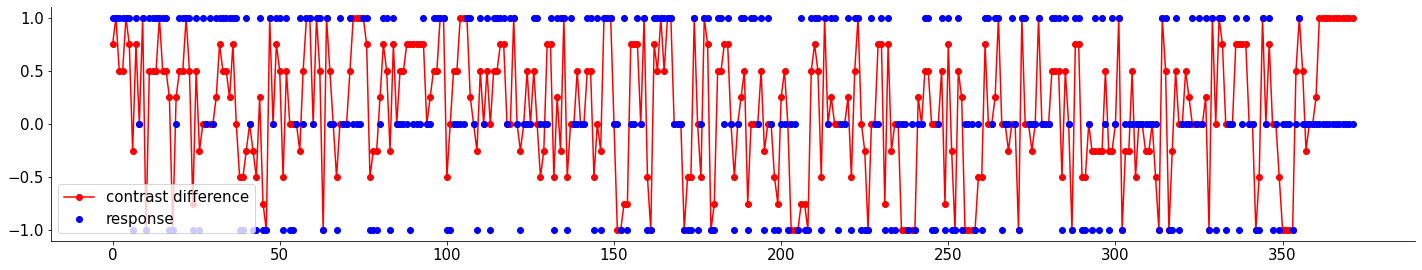

In [13]:
_, _, cont_diff, _, _, _ = get_task_difference(n_session)
plt.plot(cont_diff,'ro-', label='contrast difference')
plt.plot(dat['response'],'bo', label='response')
plt.legend()
plt.show()

In [14]:
print(len(cont_diff))
unique, counts = np.unique(cont_diff, return_counts=True) # check the contrast differences and the number of occurences
dict(zip(unique,counts))

372


{-1.0: 35,
 -0.75: 11,
 -0.5: 28,
 -0.25: 31,
 0.0: 96,
 0.25: 19,
 0.5: 60,
 0.75: 40,
 1.0: 52}

In [15]:
print('session: ', n_session)
print('contrast difference:', np.unique(cont_diff)[-1],' occurence:', counts[-1])
resp = (dat['response'][cont_diff==1])
# np.sum(resp)
# np.count_nonzero(resp==1)
# resp.shape

session:  8
contrast difference: 1.0  occurence: 52


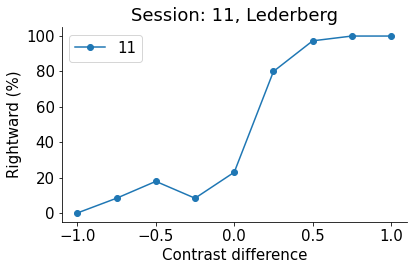

In [16]:
def get_rightward(dat, cont_diff):
    """
    Inputs: 
        * dat - data 
        * cont_diff - contrast difference between left and right
    Return:
        * rightward - % of mice respond right for each contrast difference
    """
    rightward = np.zeros(len(np.unique(cont_diff)))
    unique, counts = np.unique(cont_diff, return_counts=True) # check the contrast differences and the number of occurences

    for i, val in enumerate(np.unique(cont_diff)):
        resp = dat['response'][cont_diff==val]
        rightward[i] = np.count_nonzero(resp==1) / counts[i]*100
        
    return rightward

# ========== Select session number ==========
n_session=11
dat, _, _, _, _, _ = load_data(n_session)
_, _, cont_diff, _, _, _ = get_task_difference(n_session)
rightward = get_rightward(dat, cont_diff)

# ========== Plot ==========
fig = plt.figure(figsize=(6,4))

plt.plot(np.unique(cont_diff),rightward,'o-', label=n_session)

plt.xlabel('Contrast difference')
plt.ylabel('Rightward (%)')
plt.title('Session: %1.0f, '%n_session + dat['mouse_name'])
plt.legend()
plt.show()

### 39 Sessions

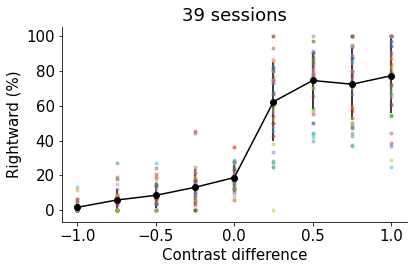

In [18]:
fig = plt.figure(figsize=(6,4))

# ========== Select session number ==========
rt_data = np.zeros((39,9))

for n_session in range(39):
    dat, _, _, _, _, _ = load_data(n_session)
    _, _, cont_diff, _, _, _ = get_task_difference(n_session)
    rightward = get_rightward(dat, cont_diff)
    rt_data[n_session,:]=rightward
    # ========== Plot ==========
    plt.plot(np.unique(cont_diff),rightward,'.', label=n_session, alpha=0.4)

# ========== Comput and plot mean and variance ==========
rt_mean = np.zeros(9)
for i in range(9):
    rt_mean[i] = np.mean(rt_data[:,i])
#     print(np.std(rt_data[:,i]))
    plt.errorbar(np.unique(cont_diff)[i], np.mean(rt_data[:,i]), np.std(rt_data[:,i]), fmt='-ko')
plt.plot(np.unique(cont_diff), rt_mean, 'k-', alpha=1)
plt.xlabel('Contrast difference')
plt.ylabel('Rightward (%)')
plt.title('39 sessions')
# plt.legend()
plt.show()

## History Dependence

In [269]:
def get_right_hist(dat, cont_diff):
    """
    Inputs: 
        * dat - trial data 
        * cont_diff - contrast difference between left and right
    Return:
        * reasy_l - % of mice respond right for each contrast difference, previous trial is easy left
        * rdiff_l - % of mice respond right for each contrast difference, previous trial is difficult left
        * reasy_r - % of mice respond right for each contrast difference, previous trial is easy right
        * rdiff_r - % of mice respond right for each contrast difference, previous trial is difficult right
    """
    unique, counts = np.unique(cont_diff, return_counts=True) # check the contrast differences and the number of occurences

    n_el = n_dl = n_er = n_dr = n_zero = 0

    # Define easy/difficult left/right (boolean array)
    easy_l = (cont_diff==-1) + (cont_diff==-0.75)
    diff_l = (cont_diff==-0.5) + (cont_diff==-0.25)
    diff_r = (cont_diff==0.25) + (cont_diff==0.5)
    easy_r = (cont_diff==0.75) + (cont_diff==1)

    reasy_l = np.zeros((easy_l.sum(),9,2)) # 59 x 9
    rdiff_l = np.zeros((diff_l.sum(),9,2)) # 52 x 9
    reasy_r = np.zeros((easy_r.sum(),9,2)) # 41 x 9
    rdiff_r = np.zeros((diff_r.sum(),9,2)) # 62 x 9
    rzero = np.zeros(((cont_diff==0).sum(),9,2)) # 126 x 9

    for i in range(len(dat['response'])-1):
        hist = cont_diff[i]                                  # previous trial difficulty (size) & direction (sign)
        idx_cont = np.where(unique==cont_diff[i+1])[0][0]   # current trial difficulty and direction label (9 unique labels)

        if hist in unique[0:2]: # easy left
            reasy_l[n_el, idx_cont,0] = dat['response'][i+1]
            reasy_l[0,idx_cont,1] +=1
            n_el += 1
        elif hist in unique[2:4]: # difficult left
            rdiff_l[n_dl, idx_cont,0] = dat['response'][i+1]
            rdiff_l[0, idx_cont,1] += 1
            n_dl += 1
        elif hist in unique[5:7]: # difficult right
            rdiff_r[n_dr, idx_cont,0] = dat['response'][i+1]
            rdiff_r[0, idx_cont,1] += 1
            n_dr += 1
        elif hist in unique[7:9]: # easy right
            reasy_r[n_er, idx_cont,0] = dat['response'][i+1]
            reasy_r[0, idx_cont,1] += 1
            n_er += 1
        elif hist == 0:
            rzero[n_zero, idx_cont,0] = dat['response'][i+1]
            rzero[0, idx_cont,1] += 1
            n_zero += 1
        else:
            print('Check: something is wrong')

    # Use np.divide(a, b, out=np.zeros(a.shape), where=b!=0) to avoid 0 division error
    r_easyr = np.divide(np.count_nonzero(reasy_r[:,:,0]==1,axis=0),
                        reasy_r[0,:,1], 
                        out=np.zeros(np.count_nonzero(reasy_r[:,:,0]==1,axis=0).shape), 
                        where=(reasy_r[0,:,1]!=0)) * 100
    r_easyl = np.divide(np.count_nonzero(reasy_l[:,:,0]==1,axis=0),
                        reasy_l[0,:,1], 
                        out=np.zeros(np.count_nonzero(reasy_l[:,:,0]==1,axis=0).shape), 
                        where=(reasy_l[0,:,1]!=0)) * 100
    r_diffr = np.divide(np.count_nonzero(rdiff_r[:,:,0]==1,axis=0),
                        rdiff_r[0,:,1], 
                        out=np.zeros(np.count_nonzero(rdiff_r[:,:,0]==1,axis=0).shape), 
                        where=(rdiff_r[0,:,1]!=0)) * 100
    r_diffl = np.divide(np.count_nonzero(rdiff_l[:,:,0]==1,axis=0),
                        rdiff_l[0,:,1], 
                        out=np.zeros(np.count_nonzero(rdiff_l[:,:,0]==1,axis=0).shape), 
                        where=(rdiff_l[0,:,1]!=0)) * 100
    r_zero = np.divide(np.count_nonzero(rzero[:,:,0]==1,axis=0),
                       rzero[0,:,1], 
                       out=np.zeros(np.count_nonzero(rzero[:,:,0]==1,axis=0).shape), 
                       where=(rzero[0,:,1]!=0)) * 100
        
    return r_easyr, r_easyl, r_diffr, r_diffl, r_zero

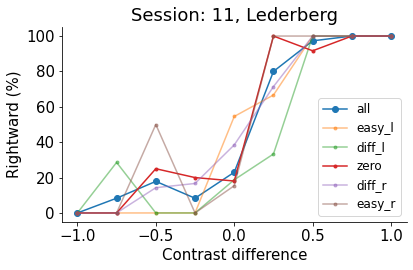

In [270]:
# ========== Select session number ==========
n_session=11
dat, _, _, _, _, _ = load_data(n_session)
_, _, cont_diff, _, _, _ = get_task_difference(n_session)
r_easyr, r_easyl, r_diffr, r_diffl, r_zero = get_right_hist(dat, cont_diff)
# ========== Plot ==========
fig = plt.figure(figsize=(6,4))

plt.plot(np.unique(cont_diff),rightward,'o-', label='all')
plt.plot(np.unique(cont_diff),r_easyl,'.-', label='easy_l', alpha=0.5)
plt.plot(np.unique(cont_diff),r_diffl,'.-', label='diff_l', alpha=0.5)
plt.plot(np.unique(cont_diff),r_zero,'.-', label='zero')
plt.plot(np.unique(cont_diff),r_diffr,'.-', label='diff_r', alpha=0.5)
plt.plot(np.unique(cont_diff),r_easyr,'.-', label='easy_r', alpha=0.5)

plt.xlabel('Contrast difference')
plt.ylabel('Rightward (%)')
plt.title('Session: %1.0f, '%n_session + dat['mouse_name'])
plt.legend(fontsize=12)
plt.show()